# Adversarial Search: Solving Tic-Tac-Toe with Pure Monte Carlo Search

## Introduction 

Multiplayer games can be implemented as:
1. Nondeterministic actions: The opponent is seen as part of an environment with nondeterministic actions. Non-determinism is the result of the unknown opponent's moves. 
2. Optimal Decisions: Minimax search (search complete game tree) and alpha-beta pruning.
3. Heuristic Alpha-Beta Tree Search: Cut off tree search and use heuristic to estimate state value. 
4. __Monte Carlo Search:__ Simulate playouts to estimate state value. 

Here we will implement search for Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). The game is a __zero-sum game__: Win by x results in +1, win by o in -1 and a tie has a value of 0. Max plays x and tries to maximize the outcome while Min plays o and tries to minimize the outcome.   

We will implement
* Pure Monte Carlo search

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py).

In [7]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

%precision 3

'%.3f'

# Pure Monte Carlo Search

See AIMA page 161ff. 

We implement a extremely simplified version.

For the current state: 
1. Simulate $N$ random playouts for each possible action and 
2. pick the action with the highest average utility.

__Important note:__ we use here a random playout policy, which ends up creating just a randomized search that works fine for this toy problem. For real applications you need to extend the code with
1. a good __playout policy__ (e.g., learned by self-play) and 
2. a __selection strategy__ (e.g., UCB1).

## Simulate playouts

In [8]:
import numpy as np

def playout(state, action, player = 'x'):
    """Perform a random playout starting with the given action on the given board 
    and return the utility of the finished game."""
    state = result(state, player, action)
    current_player = other(player)
    
    while(True):
        # reached terminal state?
        u = utility(state, player)
        if u is not None: return(u)
        
        # we use a random playout policy
        a = np.random.choice(actions(state))
        state = result(state, current_player, a)
        #print(state)
        
        # switch between players
        current_player = other(current_player)


# Playout for action 0 (top-left corner)
board = empty_board()
print(playout(board, 0))
print(playout(board, 0))
print(playout(board, 0))
print(playout(board, 0))
print(playout(board, 0))

1
1
1
-1
1


In [9]:
def playouts(board, action, player = 'x', N = 100):
    """Perform N playouts following the given action for the given board."""
    return [ playout(board, action, player) for i in range(N) ]

u = playouts(board, 0)
print("Playout results:", u)

print(f"mean utility: {np.mean(u)}")

p_win = sum(np.array(u) == +1)/len(u)
p_loss = sum(np.array(u) == -1)/len(u)
p_draw = sum(np.array(u) == 0)/len(u)
print(f"win probability: {p_win}")
print(f"loss probability: {p_loss}")
print(f"draw probability: {p_draw}")

Playout results: [1, 1, 1, 1, 1, 1, -1, 1, -1, 0, 1, 1, 1, 1, 1, 1, 0, -1, 0, 1, 0, -1, 1, -1, 1, 1, 1, 1, 0, 1, 1, 1, 1, -1, -1, -1, -1, 1, 0, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 0, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, -1, 1, 0, -1, 1, 1, -1, -1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, -1]
mean utility: 0.4
win probability: 0.64
loss probability: 0.24
draw probability: 0.12


__Note:__ This shows that the player who goes first has a significant advantage in __pure random play.__ Real players do not play randomly, a better playout policy would be good.

## Pure Monte Carlo Search

In [10]:
import math

DEBUG = 1


def pmcs(board, N = 100, player = 'x'):
    """Pure Monte Carlo Search. Returns the action that has the largest average utility.
    The N playouts are evenly divided between the possible actions."""
    global DEBUG
    
    acts = actions(board)
    n = math.floor(N/len(acts))
    if DEBUG >= 1: print(f"Actions: {acts} ({N} total playouts = {n} playouts per action)")
    
    ps = { i : np.mean(playouts(board, i, player, N = n)) for i in acts }
    if DEBUG >= 1: display(ps)
        
    action = max(ps, key=ps.get)
    return action

board = empty_board()
display(board)
%time print(pmcs(board))

print()
print("10000 playouts give a better utility estimate.")
%time print(pmcs(board, N = 10000))

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

Actions: [0, 1, 2, 3, 4, 5, 6, 7, 8] (100 total playouts = 11 playouts per action)


{0: -0.091,
 1: 0.182,
 2: 0.545,
 3: 0.727,
 4: 0.636,
 5: 0.091,
 6: 0.545,
 7: 0.000,
 8: 0.273}

3
CPU times: user 32.1 ms, sys: 30 µs, total: 32.2 ms
Wall time: 30.4 ms

10000 playouts give a better utility estimate.
Actions: [0, 1, 2, 3, 4, 5, 6, 7, 8] (10000 total playouts = 1111 playouts per action)


{0: 0.348,
 1: 0.147,
 2: 0.344,
 3: 0.153,
 4: 0.536,
 5: 0.183,
 6: 0.338,
 7: 0.217,
 8: 0.321}

4
CPU times: user 1.7 s, sys: 51.5 ms, total: 1.76 s
Wall time: 1.72 s


Looks like the center and the corners are a lot better.

## Some Tests

### x is about to win (play 8)


Board:


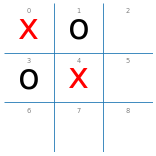


Actions: [2, 5, 6, 7, 8] (100 total playouts = 20 playouts per action)


{2: 0.700, 5: 0.500, 6: 0.900, 7: 0.700, 8: 1.000}

8

CPU times: user 12.9 ms, sys: 17.2 ms, total: 30.2 ms
Wall time: 9.82 ms


In [11]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'

print("Board:")
show_board(board)

print()
%time display(pmcs(board))

### o is about to win

Board:


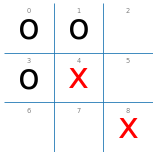


Actions: [2, 5, 6, 7] (100 total playouts = 25 playouts per action)


{2: 0.120, 5: -0.760, 6: -0.040, 7: -0.680}

2

CPU times: user 17 ms, sys: 8.28 ms, total: 25.3 ms
Wall time: 8.24 ms

Actions: [2, 5, 6, 7] (1000 total playouts = 250 playouts per action)


{2: 0.000, 5: -0.648, 6: 0.056, 7: -0.632}

6

CPU times: user 133 ms, sys: 131 ms, total: 265 ms
Wall time: 87 ms


In [12]:
board = empty_board() 
board[0] = 'o'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
board[8] = 'x'

print("Board:")
show_board(board)

print()
%time display(pmcs(board))

print()
%time display(pmcs(board, N = 1000))

### x can draw if it chooses 7

Board:


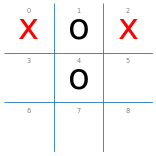


Actions: [3, 5, 6, 7, 8] (100 total playouts = 20 playouts per action)


{3: -0.400, 5: 0.100, 6: -0.350, 7: 0.050, 8: -0.300}

5

CPU times: user 22.6 ms, sys: 16.8 ms, total: 39.4 ms
Wall time: 12.8 ms


In [13]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'

print("Board:")
show_board(board)

print()
%time display(pmcs(board))

### Empty board: Only a draw an be guaranteed

Board:


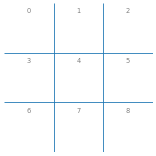


Actions: [0, 1, 2, 3, 4, 5, 6, 7, 8] (5000 total playouts = 555 playouts per action)


{0: 0.378,
 1: 0.164,
 2: 0.373,
 3: 0.276,
 4: 0.517,
 5: 0.277,
 6: 0.332,
 7: 0.196,
 8: 0.305}

4

CPU times: user 938 ms, sys: 242 ms, total: 1.18 s
Wall time: 860 ms


In [14]:
board = empty_board() 

print("Board:")
show_board(board)

print()
%time display(pmcs(board, N = 5000))

### A bad situation

Board:


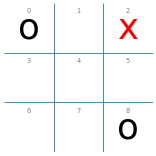


Actions: [1, 3, 4, 5, 6, 7] (100 total playouts = 16 playouts per action)


{1: -0.750, 3: -0.750, 4: 0.312, 5: -0.750, 6: -0.500, 7: -0.688}

4

CPU times: user 22.8 ms, sys: 16.9 ms, total: 39.7 ms
Wall time: 13.1 ms


In [15]:
board = empty_board() 
board[0] = 'o'
board[2] = 'x'
board[8] = 'o'

print("Board:")
show_board(board)

print()
%time display(pmcs(board))

__Note:__ It looks like random player o is very unlikely to block x and take advantage of the trap by playing the bottom left corner!

## Experiments

### Pure Monte Carlo Search vs. Random

In [16]:
def pmcs10_player(board, player = 'x'):
    action = pmcs(board, N = 10, player = player)
    return action

def pmcs100_player(board, player = 'x'):
    action = pmcs(board, N = 100, player = player)
    return action

def pmcs1000_player(board, player = 'x'):
    action = pmcs(board, N = 1000, player = player)
    return action


DEBUG = 1
print("PMCS vs. random:")
display(play(pmcs10_player, random_player, N = 1))

PMCS vs. random:
Actions: [0, 1, 2, 3, 4, 5, 6, 7, 8] (10 total playouts = 1 playouts per action)


{0: 1.000,
 1: -1.000,
 2: 1.000,
 3: 1.000,
 4: 1.000,
 5: 1.000,
 6: 1.000,
 7: -1.000,
 8: 1.000}

Actions: [2, 3, 4, 5, 6, 7, 8] (10 total playouts = 1 playouts per action)


{2: 0.000, 3: 1.000, 4: 1.000, 5: 1.000, 6: 0.000, 7: 0.000, 8: 1.000}

Actions: [2, 4, 5, 6, 8] (10 total playouts = 2 playouts per action)


{2: 1.000, 4: 1.000, 5: 0.000, 6: 1.000, 8: 1.000}

Actions: [4, 5, 6] (10 total playouts = 3 playouts per action)


{4: 0.333, 5: -1.000, 6: 1.000}

{'x': 1, 'o': 0, 'd': 0}

In [17]:
DEBUG = 0
print("PMCS (10) vs. random:")
%time display(play(pmcs10_player, random_player))

print()
print("random vs. PMCS (10)")
%time display(play(random_player, pmcs10_player))

PMCS (10) vs. random:


{'x': 91, 'o': 5, 'd': 4}

CPU times: user 567 ms, sys: 150 ms, total: 717 ms
Wall time: 511 ms

random vs. PMCS (10)


{'x': 20, 'o': 68, 'd': 12}

CPU times: user 287 ms, sys: 2.22 ms, total: 289 ms
Wall time: 272 ms


In [18]:
DEBUG = 0
print("PMCS (100) vs. random:")
%time display(play(pmcs100_player, random_player))

print()
print("random vs. PMCS (100)")
%time display(play(random_player, pmcs100_player))

PMCS (100) vs. random:


{'x': 98, 'o': 0, 'd': 2}

CPU times: user 6.03 s, sys: 228 ms, total: 6.26 s
Wall time: 6 s

random vs. PMCS (100)


{'x': 7, 'o': 82, 'd': 11}

CPU times: user 4.29 s, sys: 50.7 ms, total: 4.34 s
Wall time: 4.25 s


In [19]:
DEBUG = 0
print("PMCS (100) vs. PMCS (10):")
%time display(play(pmcs100_player, pmcs10_player))

print()
print("PMCS (10) vs. PMCS (100)")
%time display(play(pmcs10_player, pmcs100_player))

PMCS (100) vs. PMCS (10):


{'x': 88, 'o': 4, 'd': 8}

CPU times: user 6.12 s, sys: 264 ms, total: 6.39 s
Wall time: 6.07 s

PMCS (10) vs. PMCS (100)


{'x': 29, 'o': 54, 'd': 17}

CPU times: user 5.04 s, sys: 135 ms, total: 5.18 s
Wall time: 5.01 s


**Note 1:** You can try `pmcs_1000`, but it will take a few minutes to run 100 games.

**Note 2:** The important advantage about Monte Carlo Search is that we do not need to define a heuristic evaluation function to decide what boards are good.